# Cheking hill shape

    In this script, we will run a simulation of two particles one in a long trap and the other in a short trap of the cairo lattice. We will set B = 0 mT along the whole experiment and we will focus our attention in the diffusion of the particle along the trap. This way we'll be able to check the shape of the biharmonical trap. We follow the idea of: https://aortiza.github.io/icenumerics/OtherNotebooks/ForcesOfTheSimulation.html  

In [1]:
import sys
import numpy as np
from importlib import reload  
import support as sup
reload(sup)
sys.path.insert(0, '../icenumerics')

import icenumerics as ice
from icenumerics.geometry import ordering 

import matplotlib.pyplot as plt
ureg = ice.ureg

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-6.0"

In [3]:
centers, directions = sup.unit_cell_Cairo(20)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:62: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,0] = centers_toAddX
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:63: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,1] = centers_toAddY


In [4]:
centers = [[0,0,0],[0,11,0]]*ureg.um
directions = directions[:2]
centers

array([[ 0,  0,  0],
       [ 0, 11,  0]]) <Unit('micrometer')>

(-0.32999999999999996, 11.967999999999998, -0.649, 11.648999999999997)

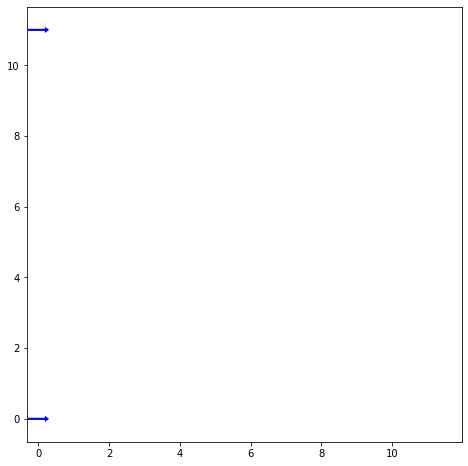

In [5]:
sp = ice.spins(centers = centers, directions = [[1,0,0],[1,0,0]]*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax1)

plt.axis('square')

In [6]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 1*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_long = ice.trap(trap_sep = 10*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

trap_short = ice.trap(trap_sep = 4.5258*ureg.um,
               height = 30*ureg.pN*ureg.nm,
               stiffness = 0.1*ureg.fN/ureg.nm)

traps = [trap_short,trap_long]

In [7]:
30*ureg.pN*ureg.nm

30 <Unit('nanometer * piconewton')>

In [8]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)

col.pad_region(12*ureg.um)

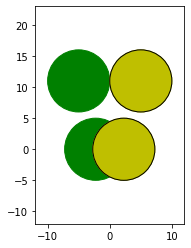

In [9]:
f, (ax1) = plt.subplots(1,1,figsize = (4,4))
col.display(ax1)

In [10]:
world = ice.world(
    field = 0*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

In [11]:
%%time
col.simulation(world,
             name = "test_new",
             include_timestamp = False,
             targetdir = output,
             framerate = 10*ureg.Hz,
             timestep = 1000*ureg.us,
             run_time = 100000*ureg.s,
             output = ["x","y","z","mux","muy","muz"])

col.run_simulation()

CPU times: user 24.2 ms, sys: 4.86 ms, total: 29.1 ms
Wall time: 11min 17s


In [12]:
col.load_simulation()

scanning file


In [13]:
col.trj

type        x          y    z      mux  muy  muz        t
frame  id                                                           
0      1      1  2.26290   0.000000  0.0   0.0000  0.0  0.0      0.0
       2      1  5.00000  11.000000  0.0   0.0000  0.0  0.0      0.0
       3      2  0.00000   0.000000  0.0   4.5258  0.0  0.0      0.0
       4      3  0.00000  11.000000  0.0  10.0000  0.0  0.0      0.0
1      1      1  2.37991   0.078355  0.0   0.0000  0.0  0.0      0.1
...         ...      ...        ...  ...      ...  ...  ...      ...
999998 4      3  0.00000  11.000000  0.0  10.0000  0.0  0.0  99999.8
999999 1      1 -2.53152   0.244312  0.0   0.0000  0.0  0.0  99999.9
       2      1 -3.58191  11.321500  0.0   0.0000  0.0  0.0  99999.9
       3      2  0.00000   0.000000  0.0   4.5258  0.0  0.0  99999.9
       4      3  0.00000  11.000000  0.0  10.0000  0.0  0.0  99999.9

[4000000 rows x 8 columns]

In [14]:
uno = col.trj.query('id == 1')

Text(0.5, 0, 'P(y)')

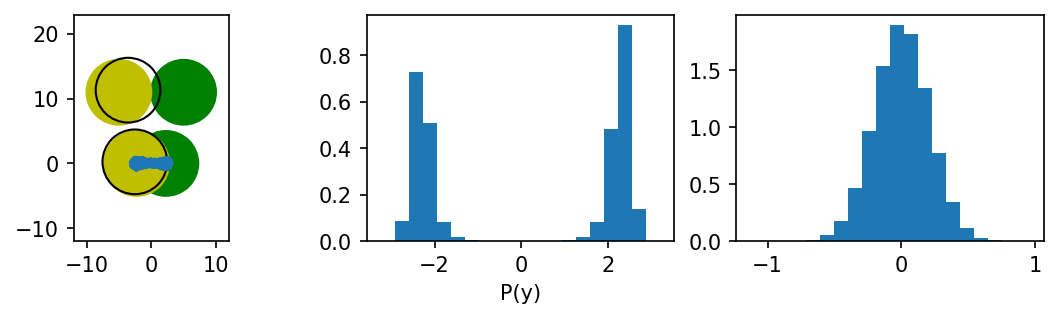

In [15]:
fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

col.display(ax = ax[0])
ax[0].plot(uno.x, uno.y)

ax[1].hist(uno.x, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(x)")
ax[2].hist(uno.y, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(y)")

In [16]:
k = col[0].trap.stiffness
d = col[0].trap.trap_sep
h = col[0].trap.height
kB = 1.38064852e-23*ureg.J/ureg.K

def bistable_trap(x,y):

    Uy = (k*y**2/2).to("pN nm")


    Ux = ((-4*x**2/d**2+1)*h).to("pN nm")
    Ux1 = (k * (abs(x)-d/2)**2 / 2).to("pN nm")

    Ux[abs(x)>(d/2)] = Ux1[abs(x)>(d/2)]

    return Ux+Uy

d,h,k

(4.5258 <Unit('micrometer')>,
 30 <Unit('nanometer * piconewton')>,
 0.1 <Unit('femtonewton / nanometer')>)

In [17]:
np.histogram(uno.x, bins = 20, density=True)

(array([0.00126194, 0.0867202 , 0.72868035, 0.50807699, 0.08332196,
        0.0180516 , 0.00546013, 0.00205569, 0.00112241, 0.00095188,
        0.0010759 , 0.00134565, 0.00222622, 0.00537021, 0.018064  ,
        0.08170346, 0.48434823, 0.92894699, 0.13945491, 0.00234404]),
 array([-3.24269   , -2.92017   , -2.59765   , -2.27513   , -1.95261   ,
        -1.63009   , -1.3075701 , -0.98505   , -0.66253006, -0.34001005,
        -0.01749003,  0.30503   ,  0.62755   ,  0.95006996,  1.27259   ,
         1.5951099 ,  1.91763   ,  2.24015   ,  2.56267   ,  2.88519   ,
         3.20771   ], dtype=float32))

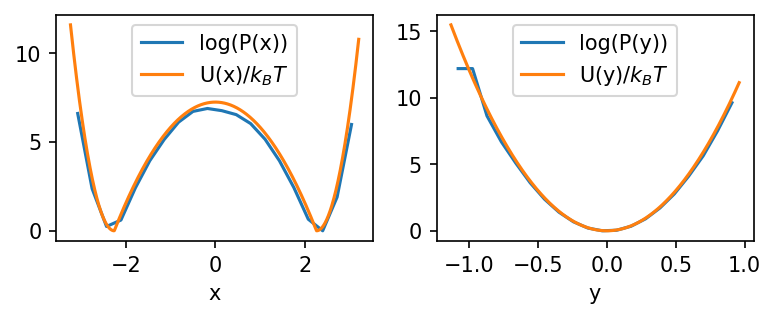

In [18]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)

## parallel dependence
[p, x] = np.histogram(uno.x, bins = 20, density=True)
ax[0].plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p), label="log(P(x))")

x = np.linspace(min(x),max(x),1000) * ureg.um
y = np.array([0])*ureg.um
T = col.sim.world.temperature

ax[0].plot(x.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude, label="U(x)/$k_BT$")
ax[0].set_xlabel("x")
ax[0].legend()

## perpendicular dependence
[p, y] = np.histogram(uno.y, bins = 20, density=True)
ax[1].plot(y[1:]-np.diff(y)/2, max(np.log(p))-np.log(p),label="log(P(y))")

x = np.array([d.magnitude/2])*d.units
y = np.linspace(min(y),max(y),1000) * ureg.um
T = col.sim.world.temperature

ax[1].plot(y.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude,label="U(y)/$k_BT$")
ax[1].set_xlabel("y")
ax[1].legend()

In [19]:
dos = col.trj.query('id == 2')
dos

,,type,x,y,z,mux,muy,muz,t
frame,id,,,,,,,,
0,2,1,5.00000,11.0000,0.0,0.0,0.0,0.0,0.0
1,2,1,4.68720,10.7482,0.0,0.0,0.0,0.0,0.1
2,2,1,5.03866,11.1164,0.0,0.0,0.0,0.0,0.2
3,2,1,5.13158,11.0497,0.0,0.0,0.0,0.0,0.3
4,2,1,4.67063,11.1083,0.0,0.0,0.0,0.0,0.4
...,...,...,...,...,...,...,...,...,...
999995,2,1,-2.30369,11.1495,0.0,0.0,0.0,0.0,99999.5
999996,2,1,-2.94187,11.1893,0.0,0.0,0.0,0.0,99999.6
999997,2,1,-3.28803,11.2437,0.0,0.0,0.0,0.0,99999.7


Text(0.5, 0, 'P(y)')

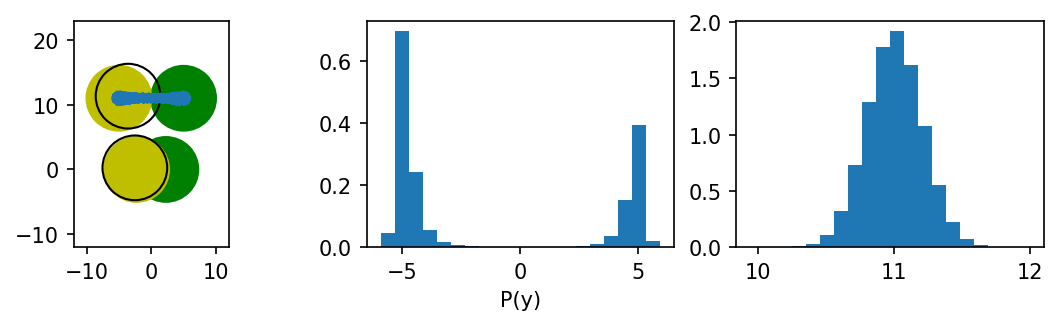

In [20]:
fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

col.display(ax = ax[0])
ax[0].plot(dos.x, dos.y)

ax[1].hist(dos.x, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(x)")
ax[2].hist(dos.y, bins=20, density=True);
ax[1].set_xlabel("x")
ax[1].set_xlabel("P(y)")

In [21]:
k = col[1].trap.stiffness
d = col[1].trap.trap_sep
h = col[1].trap.height
kB = 1.38064852e-23*ureg.J/ureg.K

def bistable_trap(x,y):

    Uy = (k*y**2/2).to("pN nm")


    Ux = ((-4*x**2/d**2+1)*h).to("pN nm")
    Ux1 = (k * (abs(x)-d/2)**2 / 2).to("pN nm")

    Ux[abs(x)>(d/2)] = Ux1[abs(x)>(d/2)]

    return Ux+Uy

d,h,k

(10 <Unit('micrometer')>,
 30 <Unit('nanometer * piconewton')>,
 0.1 <Unit('femtonewton / nanometer')>)

In [22]:
np.histogram(dos.x, bins = 20, density=True)

(array([4.56745745e-02, 6.94861514e-01, 2.41350879e-01, 5.65375573e-02,
        1.61127243e-02, 5.57281970e-03, 2.42128344e-03, 1.37637905e-03,
        9.17025257e-04, 6.51172063e-04, 5.26658542e-04, 6.04058839e-04,
        8.58133640e-04, 1.67588486e-03, 3.45777309e-03, 1.00654048e-02,
        3.49798899e-02, 1.52927797e-01, 3.93725412e-01, 1.83186256e-02]),
 array([-5.92504   , -5.3307266 , -4.736414  , -4.142101  , -3.547788  ,
        -2.953475  , -2.3591619 , -1.764849  , -1.1705359 , -0.57622296,
         0.01809001,  0.612403  ,  1.206716  ,  1.801029  ,  2.3953419 ,
         2.989655  ,  3.583968  ,  4.178281  ,  4.772594  ,  5.3669066 ,
         5.96122   ], dtype=float32))

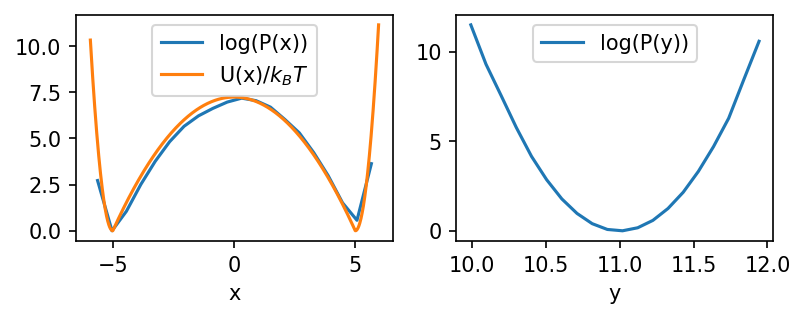

In [23]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)

## parallel dependence
[p, x] = np.histogram(dos.x, bins = 20, density=True)
ax[0].plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p), label="log(P(x))")

x = np.linspace(min(x),max(x),1000) * ureg.um
y = np.array([0])*ureg.um
T = col.sim.world.temperature

ax[0].plot(x.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude, label="U(x)/$k_BT$")
ax[0].set_xlabel("x")
ax[0].legend()

## perpendicular dependence
[p, y] = np.histogram(dos.y, bins = 20, density=True)
ax[1].plot(y[1:]-np.diff(y)/2, max(np.log(p))-np.log(p),label="log(P(y))")

x = np.array([d.magnitude/2])*d.units
y = np.linspace(min(y),max(y),1000) * ureg.um
T = col.sim.world.temperature

#ax[1].plot(y.magnitude, (bistable_trap(x,y)/(kB*T)).to(" ").magnitude,label="U(y)/$k_BT$")
ax[1].set_xlabel("y")
ax[1].legend()